In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from astra.torch.models import MLPRegressor, SIRENRegressor

import xarray as xr
import matplotlib.pyplot as plt

device = 'cuda'

In [2]:
class DeepTime(nn.Module):
    def __init__(self, x_dim, y_dim, hidden_dims, repr_dim, dropout):
        super().__init__()
        self.mlp = SIRENRegressor(x_dim, hidden_dims, repr_dim, dropout=dropout)
        # self.mlp = MLPRegressor(x_dim, hidden_dims, repr_dim, dropout=dropout)
        self.log_noise_var = nn.Parameter(torch.tensor(np.log(0.001)))

    def forward(self, x_context, y_context, x_target):
        y_mean = y_context.mean()
        y_std = y_context.std()
        y_context = (y_context - y_mean) / y_std
        context_repr = self.mlp(x_context)
        target_repr = self.mlp(x_target)

        # context_repr = torch.where(valid_idx, context_repr, 0.0)
        # y_context = torch.where(valid_idx, y_context, 0.0)

        cov = context_repr.T @ context_repr
        cov.diagonal().add_(torch.exp(self.log_noise_var))
        xty = context_repr.T @ y_context
        chol = torch.linalg.cholesky(cov)
        w = torch.cholesky_solve(xty, chol)

        y_pred = target_repr @ w
        y_pred = y_pred * y_std + y_mean
        return y_pred

In [3]:
with xr.tutorial.open_dataset('air_temperature') as ds:
    pass
train_ds = ds.sel(time="2013")
test_ds = ds.sel(time="2014")

lat_min = train_ds["lat"].min()
lat_max = train_ds["lat"].max()
lon_min = train_ds["lon"].min()
lon_max = train_ds["lon"].max()
train_ds["lat"] = (train_ds["lat"] - lat_min) / (lat_max - lat_min) * 4 - 2
train_ds["lon"] = (train_ds["lon"] - lon_min) / (lon_max - lon_min) * 4 - 2
test_ds["lat"] = (test_ds["lat"] - lat_min) / (lat_max - lat_min) * 4 - 2
test_ds["lon"] = (test_ds["lon"] - lon_min) / (lon_max - lon_min) * 4 - 2
train_ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 1460, lon: 53)
Coordinates:
  * lat      (lat) float64 2.0 1.833 1.667 1.5 1.333 ... -1.5 -1.667 -1.833 -2.0
  * lon      (lon) float64 -2.0 -1.923 -1.846 -1.769 ... 1.769 1.846 1.923 2.0
  * time     (time) time64[ns] 2013-01-01 ... 2013-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [4]:
class CustomDataset(Dataset):
    def __init__(self, ds):
        self.ds = ds

    def __len__(self):
        return len(self.ds.time) - 2

    def __getitem__(self, idx):
        y_context = self.ds.air.isel(time=[idx, idx+1]).values
        y_target = self.ds.air.isel(time=[idx+2]).values
        return torch.tensor(y_context.reshape(-1, 1)).float(), torch.tensor(y_target.reshape(-1, 1)).float()
    
train_dataset = CustomDataset(train_ds)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
for y_context, y_target in train_loader:
    print(y_context.shape, y_target.shape)
    break

lats = train_ds.lat.values
lons = train_ds.lon.values
times = np.array([0.0, 0.5])
Times, Lats, Lons = np.meshgrid(times, lats, lons, indexing='ij')
features = torch.tensor(np.stack([Times.ravel(), Lats.ravel(), Lons.ravel()], axis=-1)).float().to(device)
times = np.array([1.0])
Times, Lats, Lons = np.meshgrid(times, lats, lons, indexing='ij')
target_features = np.stack([Times.ravel(), Lats.ravel(), Lons.ravel()], axis=-1)
target_features = torch.tensor(target_features).float().to(device)
print(features.shape, target_features.shape)

model = DeepTime(3, 1, [256]*4, 64, 0.05).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

vmodel = torch.vmap(model, in_dims=(None, 0, None), out_dims=0, randomness="different")

epochs = 100
pbar = tqdm(range(epochs))
for epoch in pbar:
    epoch_loss = 0
    for y_context, y_target in train_loader:
        y_context = y_context.to(device)
        y_target = y_target.to(device)
        y_pred = vmodel(features, y_context, target_features)
        loss = F.mse_loss(y_pred, y_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    pbar.set_postfix({"loss": epoch_loss / len(train_loader)})

torch.Size([16, 2650, 1]) torch.Size([16, 1325, 1])
torch.Size([2650, 3]) torch.Size([1325, 3])


  0%|          | 0/50 [00:00<?, ?it/s]

In [5]:
test_dataset = CustomDataset(test_ds)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)
y_preds = []
y_trues = []

with torch.no_grad():
    for y_context, y_target in tqdm(test_loader):
        y_context = y_context.to(device)
        y_target = y_target.to(device)
        y_pred = vmodel(features, y_context, target_features)
        y_preds.append(y_pred.cpu().detach().numpy())
        y_trues.append(y_target.cpu().detach().numpy())
    
y_preds = np.concatenate(y_preds, axis=0)
y_trues = np.concatenate(y_trues, axis=0)
rmse = np.sqrt(np.mean((y_preds - y_trues)**2))
print(rmse)

  0%|          | 0/1458 [00:00<?, ?it/s]

2.4664807


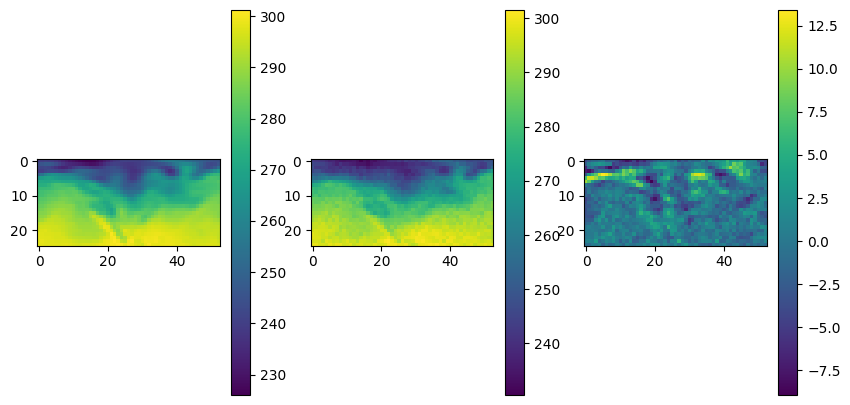

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

j = 50
ax[0].imshow(y_trues[j][:25*53].reshape(25, 53))
ax[1].imshow(y_preds[j][:25*53].reshape(25, 53))
ax[2].imshow(y_trues[j][:25*53].reshape(25, 53) - y_preds[j][:25*53].reshape(25, 53))
# add colorbars
fig.colorbar(ax[0].imshow(y_trues[j][:25*53].reshape(25, 53)), ax=ax[0])
fig.colorbar(ax[1].imshow(y_preds[j][:25*53].reshape(25, 53)), ax=ax[1])
fig.colorbar(ax[2].imshow(y_trues[j][:25*53].reshape(25, 53) - y_preds[j][:25*53].reshape(25, 53)), ax=ax[2])

In [7]:
y_trues = []
y_preds = []
y_pred = y_context.reshape(2, 25, 53)[1]
for y_context, y_target in tqdm(test_loader):
    break

with torch.no_grad():
    for _, y_target in tqdm(test_loader):
        y_context.reshape(2, 25, 53)[0] = y_context.reshape(2, 25, 53)[1]
        y_context.reshape(2, 25, 53)[1] = y_pred.reshape(25, 53)
        y_context = y_context.to(device)
        y_target = y_target.to(device)
        y_pred = vmodel(features, y_context, target_features)
        y_preds.append(y_pred.cpu().detach().numpy())
        y_trues.append(y_target.cpu().detach().numpy())
        
y_preds = np.concatenate(y_preds, axis=0)
y_trues = np.concatenate(y_trues, axis=0)
print(y_preds.shape, y_trues.shape)

  0%|          | 0/1458 [00:00<?, ?it/s]

  0%|          | 0/1458 [00:00<?, ?it/s]

(1458, 1325, 1) (1458, 1325, 1)


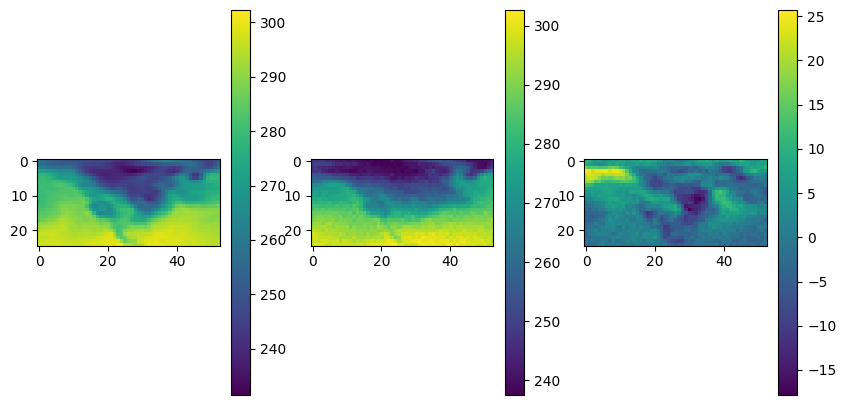

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

j = 100
ax[0].imshow(y_trues[j][:25*53].reshape(25, 53))
ax[1].imshow(y_preds[j][:25*53].reshape(25, 53))
ax[2].imshow(y_trues[j][:25*53].reshape(25, 53) - y_preds[j][:25*53].reshape(25, 53))
# add colorbars
fig.colorbar(ax[0].imshow(y_trues[j][:25*53].reshape(25, 53)), ax=ax[0])
fig.colorbar(ax[1].imshow(y_preds[j][:25*53].reshape(25, 53)), ax=ax[1])
fig.colorbar(ax[2].imshow(y_trues[j][:25*53].reshape(25, 53) - y_preds[j][:25*53].reshape(25, 53)), ax=ax[2])